# Retirement Planner

---

## Environment Setup

In [1]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [2]:
# Set the random seed for resutls reproducibility (for testing purposes only)
np.random.seed(42)

---

## Portfolio Planner

In this activity, you will use the Alpaca API to grab historical data for a `60/40` portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [3]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

# Data Collection

In this step, you will need to use the Alpaca api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [4]:
# Subset your tickers, then pull returns data:
# Set the ticker
ticker = ["SPY", "AGG"]

# Set timeframe to '1D'
timeframe = "1D"

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp('2019-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2019-12-31', tz='America/New_York').isoformat()

# Get 1 year's worth of historical data for SPY and AGG
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

# Drop unnecessary columns
df = df.drop(
    columns=['open', 'high', 'low', 'volume'],
    level=1
)

In [5]:
# Display sample data
df.head()

,AGG,SPY
,close,close
2019-01-02 00:00:00-05:00,106.585,249.89
2019-01-03 00:00:00-05:00,107.020,244.46
2019-01-04 00:00:00-05:00,106.695,252.41
2019-01-07 00:00:00-05:00,106.470,254.40
2019-01-08 00:00:00-05:00,106.420,256.65


---

## Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:

1. Calculate the daily returns for the SPY and AGG closing prices.

2. Calculate volatility for both the SPY and AGG closing prices.

3. Find the last day's closing price for both stocks and save those as variables

4. Run a Monte Carlo Simulation of at least `100` iterations and generate at least `30` years of closing prices

**Hint:** There are `252` trading days per year, so the number of records to generate for each Monte Carlo run will be `252 days * 30 years`.

In [6]:
# Calculate the daily roi for the stocks
daily_returns = df.pct_change()

# Display sample data
daily_returns = daily_returns.dropna()
daily_returns.head()


,AGG,SPY
,close,close
2019-01-03 00:00:00-05:00,0.004081,-0.021730
2019-01-04 00:00:00-05:00,-0.003037,0.032521
2019-01-07 00:00:00-05:00,-0.002109,0.007884
2019-01-08 00:00:00-05:00,-0.000470,0.008844
2019-01-09 00:00:00-05:00,0.000564,0.004130


In [7]:
# Compute daily volatility
volatility = daily_returns.std()*(252**0.5)

print(volatility)

AGG  close    0.033156
SPY  close    0.124139
dtype: float64


In [8]:
# Save the last day's closing price
agg_last_price = df['AGG']['close'][-1]
spy_last_price = df['SPY']['close'][-1]

In [31]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252 * 30
monte_carlo = pd.DataFrame()

In [32]:
avg_daily_return_agg = daily_returns.mean()['AGG']['close']
avg_daily_return_spy = daily_returns.mean()['SPY']['close']
print(avg_daily_return_spy)
print(avg_daily_return_agg)

0.0010401250682146959
0.00021276976507473064


In [33]:
std_dev_daily_return_agg = daily_returns.std()['AGG']['close']
std_dev_daily_return_spy = daily_returns.std()['SPY']['close']
print(std_dev_daily_return_agg)
print(std_dev_daily_return_spy)

0.0020886019741764646
0.007820053413439366


In [34]:
# Run the Monte Carlo Simulation
simulated_price_df = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

for n in range(number_simulations):
    simulated_agg_prices = [agg_last_price]
    simulated_spy_prices = [spy_last_price]
    for i in range(number_records):
        simulated_agg_price = simulated_agg_prices[-1] * (1 + np.random.normal(avg_daily_return_agg, std_dev_daily_return_agg))
        simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(avg_daily_return_spy, std_dev_daily_return_spy))
        
        simulated_agg_prices.append(simulated_agg_price)
        simulated_spy_prices.append(simulated_spy_price)

    simulated_price_df["AGG prices"] = pd.Series(simulated_agg_prices)
    simulated_price_df["SPY prices"] = pd.Series(simulated_spy_prices)
    
    simulated_daily_returns = simulated_price_df.pct_change()
    
    weights = [0.4, 0.6]
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    portfolio_cumulative_returns[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

In [35]:
# Check that the simulation ran successfully
portfolio_cumulative_returns

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.998489,1.006279,0.991991,0.993075,1.003806,1.002939,1.008633,0.996375,1.000870,1.002126,...,1.010246,0.993545,0.998560,0.998447,1.002111,0.995760,1.008200,1.005168,1.003183,1.000118
2,1.001142,1.012315,0.995476,0.993335,1.000890,1.008339,1.001413,0.993561,1.003352,0.996241,...,1.011327,0.996170,0.987976,1.000213,1.000351,0.988121,1.006258,1.015231,1.011431,1.000105
3,1.000886,1.005057,0.991404,0.997839,1.004635,1.009627,1.005148,0.992702,1.004731,1.001562,...,1.008137,0.996146,0.988678,1.004051,1.006098,0.986341,1.009924,1.020764,1.013749,1.009678
4,1.005646,1.008703,0.991230,1.004617,1.006201,1.001876,1.005367,0.993625,1.014296,1.002179,...,1.006612,1.003730,0.993884,0.994669,1.005642,0.988297,1.011136,1.017644,1.012717,1.008094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,124.556173,242.451344,471.561703,167.405598,261.713573,155.605310,164.972191,292.574237,265.368753,296.145594,...,220.745231,185.248613,215.742243,171.322223,79.436759,219.813558,181.361579,149.518162,412.485734,99.452269
7557,124.000858,243.074835,470.418103,167.378083,261.113067,156.834177,164.684769,294.892245,266.188786,296.659390,...,219.904132,184.865941,215.652644,172.263338,79.637748,220.028001,180.099301,149.676240,411.164184,99.427950
7558,124.523071,244.276949,463.900760,166.408897,262.741458,156.182477,165.835403,297.179379,267.448434,294.377955,...,218.426618,185.127870,214.747544,173.234289,79.584646,219.802044,181.275280,149.714964,410.269302,99.567905
7559,124.249822,244.554797,458.914854,165.725559,262.337103,155.198578,167.006457,294.668826,268.570579,294.028034,...,218.041783,184.402907,215.297645,172.445101,79.765491,220.569491,180.351464,149.666324,404.838527,99.485377


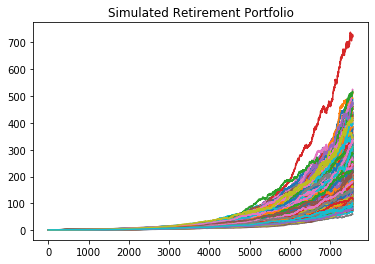

In [36]:
# Visualize the Simulation
plot_title = 'Simulated Retirement Portfolio'
portfolio_cumulative_returns.plot(legend=None, title=plot_title)

In [41]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
last_price_yr20 = portfolio_cumulative_returns.iloc[5040]
print(last_price_yr20)

0      28.206485
1      40.764040
2      70.690458
3      22.211929
4      57.188785
         ...    
495    38.064279
496    32.021700
497    28.166845
498    70.611827
499    21.420283
Name: 5040, Length: 500, dtype: float64


In [40]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
last_price_yr30 = portfolio_cumulative_returns.iloc[-1,:]
print(last_price_yr30)

0      125.070198
1      244.481378
2      458.499159
3      165.723957
4      262.228696
          ...    
495    219.638672
496    180.633829
497    151.139604
498    407.716521
499     99.964030
Name: 7560, Length: 500, dtype: float64


In [44]:
# Display the 90% confidence interval for the ending returns
confidence_interval = last_price_yr30.quantile(q=[0.01, 0.9])
confidence_interval

0.01     75.218493
0.90    330.955731
Name: 7560, dtype: float64

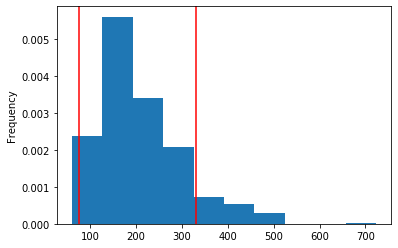

In [45]:
# Visualize the distribution of the ending returns
plt.figure();
last_price_yr30.plot(kind='hist', density=True)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

---

## Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at `30` years for the `10th`, `50th`, and `90th` percentiles?

2. Given an initial investment of `$20,000`, what is the expected return in dollars at the `10th`, `50th`, and `90th` percentiles?

3. Given the current projected annual income from the Plaid analysis, will a `4%` withdrawal rate meet or exceed that value at the `10th` percentile? Note: This is basically determining if retirement income is equivalent to current income.

4. How would a `50%` increase in the initial investment amount affect the `4%` retirement withdrawal? In other words, what happens if the initial investment had been bigger?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [46]:
# Compute cumulative returns
confidence_interval = last_price_yr30.quantile(q=[0.01, .5, 0.9])
confidence_interval

0.01     75.218493
0.50    186.888526
0.90    330.955731
Name: 7560, dtype: float64

### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [54]:
# Set initial investment
investment_amount = 20000

# Compute expected portfolio return
investment_pnl_10_bound = investment_amount * confidence_interval.iloc[0]
investment_pnl_50_bound = investment_amount * confidence_interval.iloc[1]
investment_pnl_90_bound = investment_amount * confidence_interval.iloc[2]
investment_pnl_10_bound = str(round(investment_pnl_10_bound, 2))
investment_pnl_50_bound = str(round(investment_pnl_50_bound, 2))
investment_pnl_90_bound = str(round(investment_pnl_90_bound, 2))
print(f'10th percentile: ${investment_pnl_10_bound}')
print(f'50th percentile: ${investment_pnl_50_bound}')
print(f'90th percentile: ${investment_pnl_90_bound}')

10th percentile: $1504369.86
50th percentile: $3737770.52
90th percentile: $6619114.61


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [ ]:
# Set Plaid's projected income

# Calculate the 4% withdrawal for the ending return as retirement income

# Determine if the retirement income meets or exceeds the current projected income


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [ ]:
# Re-calculate the retirement income with a 50% increase in the initial investment amount


### Optional Challenge

Use the Monte Carlo data and calculate the cumulative returns at the `5%`, `50%`, and `95%` quartiles and plot this data as a line chart to see how the cumulative returns change over the life of the investment.

In this section, you need to calculate and plot the cumulative returns for the median and `90%` confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [ ]:
# Compute projected returns

# Display sample data


In [ ]:
# Plot the cumulative returns over time


In [ ]:
# Compute portfolio performance over time

# Plot projected performance over time
